# Übungsblatt 10 #

### Alice Ziegler, Daniel Schneider ###

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import random
import math

### Datensätze einlesen und plotten ###

In [2]:
aggregate = pd.read_csv("data/aggregate.csv")

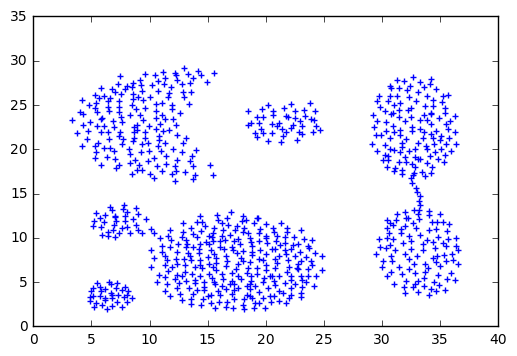

In [3]:
plt.scatter(aggregate["x"],aggregate["y"],marker="+")
plt.show()

Wähle als Clustergröße $7$

In [4]:
mouse = pd.read_csv("data/mouse.csv")

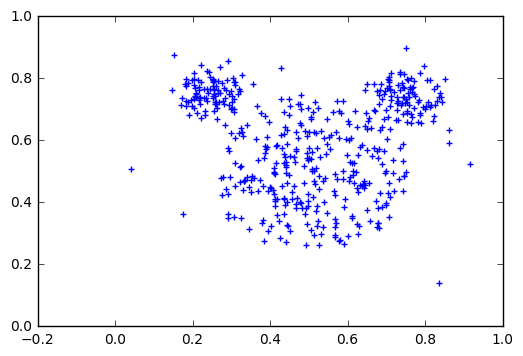

In [5]:
plt.scatter(mouse["x"],mouse["y"],marker="+")
plt.show()

Wähle als Clustergröße $3$

In [6]:
t48k = pd.read_csv("data/t48k.csv")

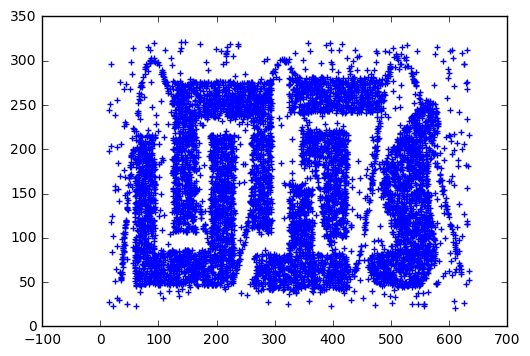

In [7]:
plt.scatter(t48k["x"],t48k["y"],marker="+")
plt.show()

Wähle als Clustergröße $6$

In [8]:
jain = pd.read_csv("data/jain.csv")

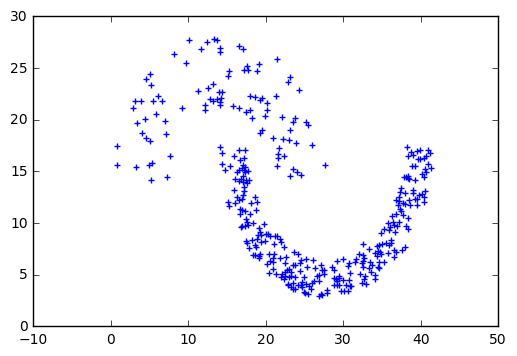

In [9]:
plt.scatter(jain["x"],jain["y"],marker="+")
plt.show()

Wähle als Clustergröße $2$

In [10]:
spiral = pd.read_csv("data/spiral.csv")

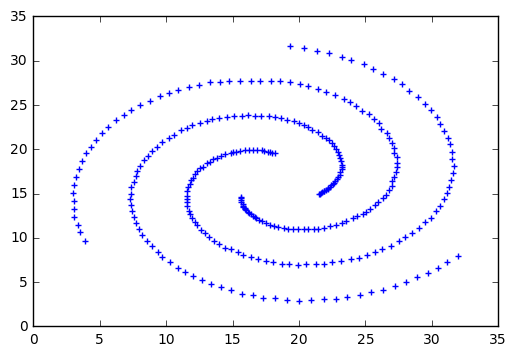

In [11]:
plt.scatter(spiral["x"],spiral["y"],marker="+")
plt.show()

Wähle als Clustergröße $3$

In [12]:
datas = [aggregate, mouse, t48k, jain, spiral]

In [47]:
clusterSizes = [5,3,6,2,3]

## Aufgabe 10.1: Expectation Maximization ##

### Funktionen zur Durchführung des Clusterings ###

In [13]:
def probK(x,piK,muK,sigmaK):
    tmp = scipy.stats.multivariate_normal.pdf(x,muK,sigmaK,allow_singular=True)
    return piK * np.nan_to_num(tmp)

In [14]:
def prob(x,pi,mu,sigma):
    summe = 0
    for k in range(pi.shape[0]):
        summe += probK(x,pi[k],mu[k],sigma[k])
    return summe

In [15]:
def gammaFunc(x,pi,mu,sigma,k):
    zaehler = probK(x,pi[k],mu[k],sigma[k])
    nenner = prob(x,pi,mu,sigma)
    
    return zaehler / nenner

In [16]:
def randomMatrix(k,n,a):
    mats = np.empty([k,n,n])
    for i in range(k):
        A = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
        A = A*np.transpose(A)
        D_half = np.diag(np.diag(A)**(-0.5))
        C = D_half*A*D_half
        mats[i] = C
    return mats

In [159]:
def EM(x, k):
    N,d = x.shape
     
    mu = np.random.uniform(x.min(),x.max(),(k,d))
    sigma = randomMatrix(k,d,(x.max()-x.min())/4) #np.random.uniform(0,1,(k,d,d))
    pi = np.random.uniform(0,1,k)
    
    # E-Schritt
    gamma = np.empty([N,k])
    for j in range(k):
        gamma[:,j] = gammaFunc(x.values, pi, mu, sigma, j)
    
    #return(gamma)
    gammaPrev = np.zeros_like(gamma)
    
    counter = 0
    while(not(np.isclose(gamma,gammaPrev).all())):
        gammaPrev = gamma.copy()
        
        # M-Schritt
        Ns = [None] * k
        for j in range(k):
            #N_k
            Ns[j] = np.nansum(gamma[:,j], axis=0)
            
            #mu_k
            summe = 0
            for i in range(N):
                summe += gamma[i,j] * x.values[i]
            mu[j] = 1/Ns[j] * summe
                    
            #sigma_k
            summe = 0
            for i in range(N):
                summe += gamma[i,j] * np.dot(
                    np.transpose((x.values[i] - mu[j])[np.newaxis]), (x.values[i] - mu[j])[np.newaxis]
                )
            sigma[j] = 1/Ns[j] * summe
            
            #pi_k
            pi[j] = Ns[j]/N

        mu = np.nan_to_num(mu)
        sigma = np.nan_to_num(sigma)
        pi = np.nan_to_num(pi)
        
        
        # E-Schritt
        for j in range(k):
            gamma[:,j] = gammaFunc(x, pi, mu, sigma, j)
        
        counter += 1
        
        if(counter == -1):
            #print(gamma)
            print(Ns)
            print(mu)
            print(sigma)
            print(pi)
        #elif(counter > 6):
        #    break
        #print(counter)
    return gamma

### Funktion zum Plotten der Cluster ###

In [24]:
def plotClusters(data,clusterProbs,plot):
    cmap = plt.get_cmap('jet', clusterProbs.shape[1])
    colorIDs = [None] * clusterProbs.shape[0]

    for i in range(clusterProbs.shape[0]):
        colors = np.zeros([3])
        for j in range(clusterProbs.shape[1]):
            colors += np.asarray(cmap(j)[0:3]) * clusterProbs[i,j]

        colorIDs[i] = np.round(colors,decimals=3)
    #print(colorIDsAggregate0)     
    plot.scatter(data["x"],data["y"], c=colorIDs, cmap=cmap, marker="+")

### Testen der Implementierung mit den Datensätzen `aggregate` und `mouse` ###

In [62]:
clustersEM = [None] * 2

In [166]:
clustersEM[0] = EM(datas[0], clusterSizes[0])

In [161]:
clustersEM[1] = EM(datas[1], clusterSizes[1])

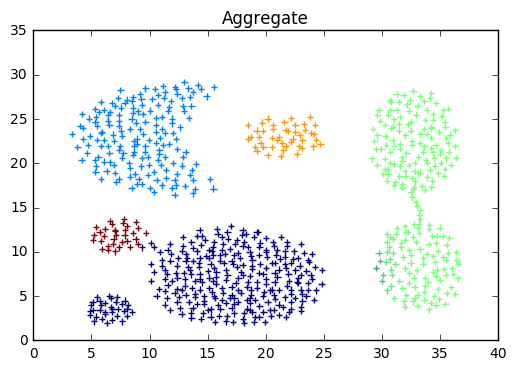

In [167]:
plotClusters(datas[0],clustersEM[0],plt)
plt.title("Aggregate")
plt.show()

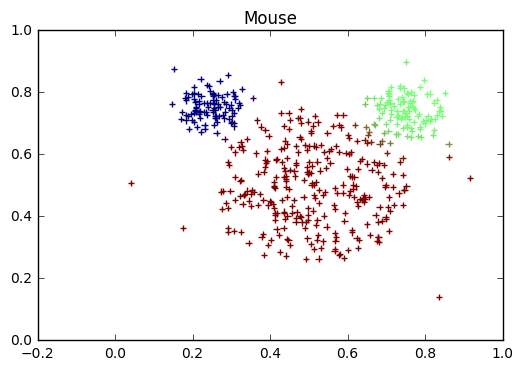

In [165]:
plotClusters(datas[1],clustersEM[1],plt)
plt.title("Mouse")
plt.show()

## Aufgabe 10.2: Non-Convex Clustering ##

### $k$-means ###

In [90]:
def kMeans(data,k):
    N = data.shape[0]
    
    ms = data.sample(n=k).reset_index(drop=True)
    msPrev = pd.DataFrame(np.zeros_like(ms))
    
    while(not((np.isclose(ms.values,msPrev.values)).all())):
        msPrev = ms.copy()
        bs = np.zeros([N,k])
        
        #print(ms)
        
        #Berechnung der bij-Matrix
        for i in range(N):
            minDist = float('inf')

            for j in range(k):
                dist = np.linalg.norm(data.loc[i] - ms.loc[j])

                if(dist < minDist):
                    minDist = dist
                    minDistClass = j

            bs[i,minDistClass] = 1

        #Anpassung der mj
        for j in range(k):
            zaehler = np.sum(np.c_[bs[:,j],bs[:,j]] * data)
            nenner = np.sum(bs[:,j])

            ms.loc[j] = zaehler/nenner
        #print(ms)
        #print(ms.equals(msPrev))
    #classIDs = np.dot(bs, range(bs.shape[1]))
    return bs

### fuzzy-$c$-Means

In [75]:
def fuzzyCMeans(data,k, p=2):
    N = data.shape[0]
    
    ms = data.sample(n=k).reset_index(drop=True)
    msPrev = pd.DataFrame(np.zeros_like(ms))
    
    while(not((np.isclose(ms.values,msPrev.values)).all())):
        msPrev = ms.copy()
        us = np.zeros([N,k])
        
        #Berechnung der uij-Matrix
        for i in range(N):
            minDist = float('inf')

            for j in range(k):
                distMj = np.square(np.linalg.norm(ms.loc[j] - data.loc[i]))
                
                summe = 0
                for l in range(k):
                    distMl = np.square(np.linalg.norm(ms.loc[l] - data.loc[i]))
                    
                    summe += np.power(distMj/distMl,(p/(p-1)))
                    #print(summe)
                
                us[i,j] = 1/summe
        
        #print(us)
        
        #Anpassung der mj
        for j in range(k):
            usP = np.power(us[:,j],p)
            
            zaehler = np.nansum(np.c_[usP,usP] * data, axis=0)
            nenner = np.nansum(usP, axis=0)

            ms.loc[j] = zaehler/nenner
        #print(ms)
    return us

### Agglomeratives Clustering ###

#### Funktionen zur Berechnung einer Distanzmatrix ####

In [76]:
def dist(x,y,dtypes,columns,normalize):
    
    dist = 0
    for f in range(len(columns)):
        
        if dtypes[f].name == "category":
            if x[attribs[f]].cat.ordered:
                dist += distOrdinal(x[columns[f]],y[columns[f]])
            else:
                dist += distNominal(x[columns[f]],y[columns[f]])
        else:
            dist += distNumeric(x[columns[f]],y[columns[f]],normalize[f])
    
    return dist

In [77]:
def distOrdinal(x,y):
    rankCount = len(x.cat.categories)
    
    rankX = (int(x.cat.codes))/(rankCount - 1)
    rankY = (int(y.cat.codes))/(rankCount - 1)    
    dist = abs(rankX - rankY)
    
    return dist

In [78]:
def distNominal(x,y):
    if x == y:
        dist = 0
    else:
        dist = 1
    
    return dist

In [79]:
def distNumeric(x,y,normalize):
    dist = abs(float(x) - float(y))/(normalize)
    
    return dist

In [80]:
def metadata(data):
    types = data.dtypes
    columns = data.columns
    
    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    normalize = (maxs - mins)
    
    return types,columns,normalize

In [81]:
def distMatrix(data1,data2,excludeAttributes):
    data1 = data1.drop(excludeAttributes,axis=1)
    data2 = data2.drop(excludeAttributes,axis=1)
    
    if data1.equals(data2):
        symetrical = True
    else:
        symetrical = False
    
    types,columns,normalize = metadata(data1)
        
    array = np.empty([data1.shape[0], data2.shape[0]])
        
    for i in range(data1.shape[0]):        
        for j in range(data2.shape[0]):
            if (symetrical and j < i):
                array[i,j] = array[j,i]
            else:
                array[i,j] = dist(data1.iloc[[i]],data2.iloc[[j]],types,columns,normalize)
        
    return array

#### Clustering-Algorithmus ####

In [107]:
def agglomerativeClustering(data, k, linkage, dist=None):
    
    if dist == None:
        dist = distMatrix(data,data,[])
    
    N = dist.shape[0]
    
    for i in range(N):
        dist[i,i] = None
        
    groups = [None] * N
    for i in range(N):
        groups[i] = data.loc[[i]]
    
    #print(groups)
    for i in range(N-k): #(10):#
        N = dist.shape[0]
        
        m = np.nanargmin(dist)
        index0 = m//N
        index1 = m%N
        
        groups[index0] = groups[index0].append(groups[index1])
        del(groups[index1])
        
        for i in range(N):
            #print("Old:"+str(dist[index0,i] - dist[index1,i]))
            if linkage == "single":
                dist[index0,i] = min(dist[index0,i],dist[index1,i])
            elif linkage == "complete":
                dist[index0,i] = max(dist[index0,i],dist[index1,i])
            
            dist[i,index0] = dist[index0,i]
            #print("New:"+str(dist[index0,i]))
        
        
        dist = np.delete(dist,index1,axis=0)
        dist = np.delete(dist,index1,axis=1)
        
    return groups

In [183]:
def agglomerativeClusteringSingle(data, k, dist = None):
    groups = agglomerativeClustering(data, k, "single", dist)
    
    bs = np.zeros([data.shape[0],k])
    
    for i in range(len(groups)):
        for j in groups[i].index.tolist():
            bs[j,i] = 1
    
    return bs

In [182]:
def agglomerativeClusteringComplete(data, k, dist = None):
    groups = agglomerativeClustering(data, k, "complete", dist)

    bs = np.zeros([data.shape[0],k])
    
    for i in range(len(groups)):
        for j in groups[i].index.tolist():
            bs[j,i] = 1
    
    return bs

In [184]:
functions = [kMeans,fuzzyCMeans,agglomerativeClusteringSingle,agglomerativeClusteringComplete,EM]

### Durchführung des Clusterings auf dem `t48k`-Datensatz ####

In [85]:
clustersT48k = [None] * 5

In [104]:
clustersT48k[0] = functions[0](datas[2], clusterSizes[2])

In [105]:
clustersT48k[1] = functions[1](datas[2], clusterSizes[2])

In [147]:
distMatrixT48k = distMatrix(datas[2],datas[2],[])

In [194]:
clustersT48k[2] = functions[2](datas[2], clusterSizes[2], distMatrixT48k)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


In [195]:
clustersT48k[3] = functions[3](datas[2], clusterSizes[2], distMatrixT48k)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


In [198]:
clustersT48k[4] = functions[4](datas[2], clusterSizes[2])

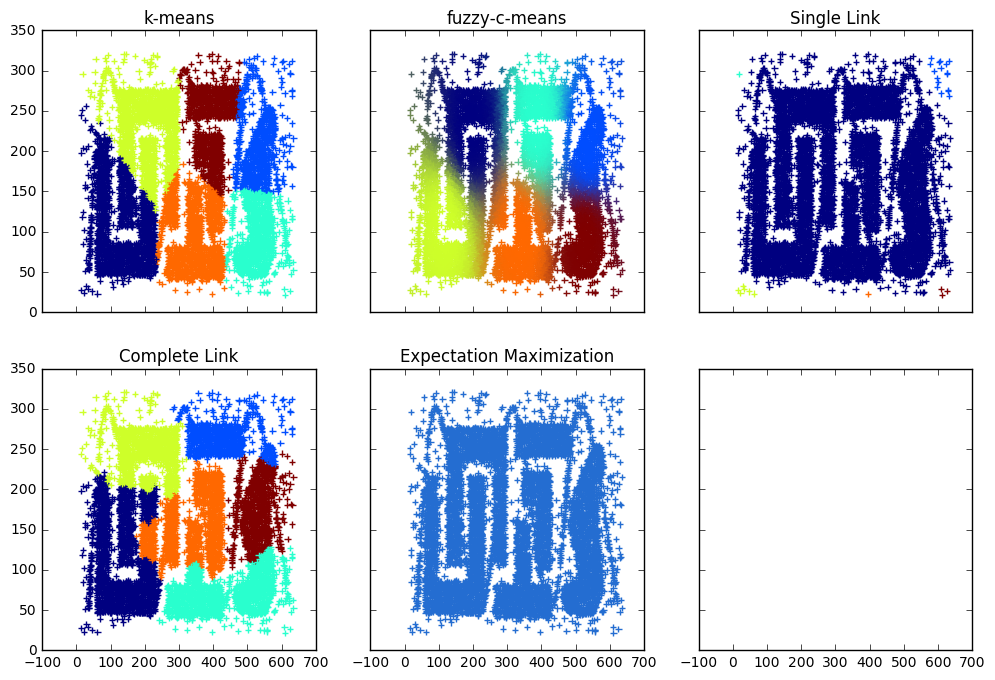

In [199]:
plt.close('all')
mpl.rcParams['figure.figsize'] = (12,8)

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, sharey='all', sharex='all')

plotClusters(datas[2],clustersT48k[0],ax0)
ax0.set_title("k-means")

plotClusters(datas[2],clustersT48k[1],ax1)
ax1.set_title("fuzzy-c-means")

plotClusters(datas[2],clustersT48k[2],ax2)
ax2.set_title("Single Link")

plotClusters(datas[2],clustersT48k[3],ax3)
ax3.set_title("Complete Link")

plotClusters(datas[2],clustersT48k[4],ax4)
ax4.set_title("Expectation Maximization")

plt.show()

mpl.rcParams['figure.figsize'] = (6,4)

### Durchführung des Clusterings auf dem `jain`-Datensatz ####

In [116]:
clustersJain = [None] * 5

In [117]:
clustersJain[0] = functions[0](datas[3], clusterSizes[3])

In [118]:
clustersJain[1] = functions[1](datas[3], clusterSizes[3])

In [119]:
clustersJain[2] = functions[2](datas[3], clusterSizes[3])

In [120]:
clustersJain[3] = functions[3](datas[3], clusterSizes[3])

In [133]:
clustersJain[4] = functions[4](datas[3], clusterSizes[3])

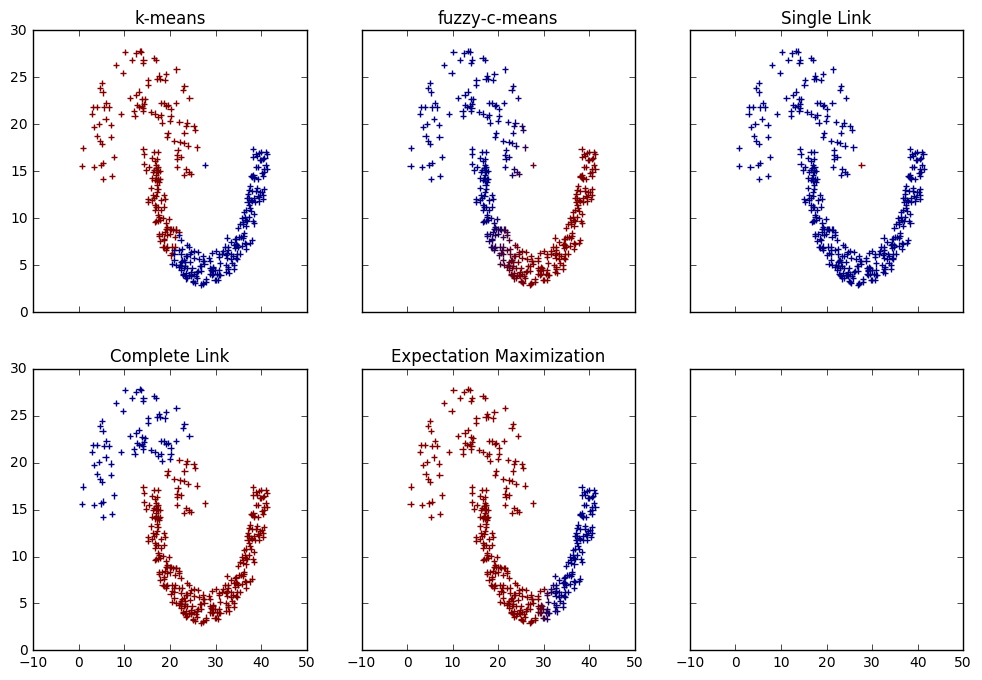

In [135]:
plt.close('all')
mpl.rcParams['figure.figsize'] = (12,8)

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, sharey='all', sharex='all')

plotClusters(datas[3],clustersJain[0],ax0)
ax0.set_title("k-means")

plotClusters(datas[3],clustersJain[1],ax1)
ax1.set_title("fuzzy-c-means")

plotClusters(datas[3],clustersJain[2],ax2)
ax2.set_title("Single Link")

plotClusters(datas[3],clustersJain[3],ax3)
ax3.set_title("Complete Link")

plotClusters(datas[3],clustersJain[4],ax4)
ax4.set_title("Expectation Maximization")

plt.show()

mpl.rcParams['figure.figsize'] = (6,4)

### Durchführung des Clusterings auf dem `spiral`-Datensatz ####

In [136]:
clustersSpiral = [None] * 5

In [137]:
clustersSpiral[0] = functions[0](datas[4], clusterSizes[4])

In [138]:
clustersSpiral[1] = functions[1](datas[4], clusterSizes[4])

In [139]:
clustersSpiral[2] = functions[2](datas[4], clusterSizes[4])

In [140]:
clustersSpiral[3] = functions[3](datas[4], clusterSizes[4])

In [144]:
clustersSpiral[4] = functions[4](datas[4], clusterSizes[4])

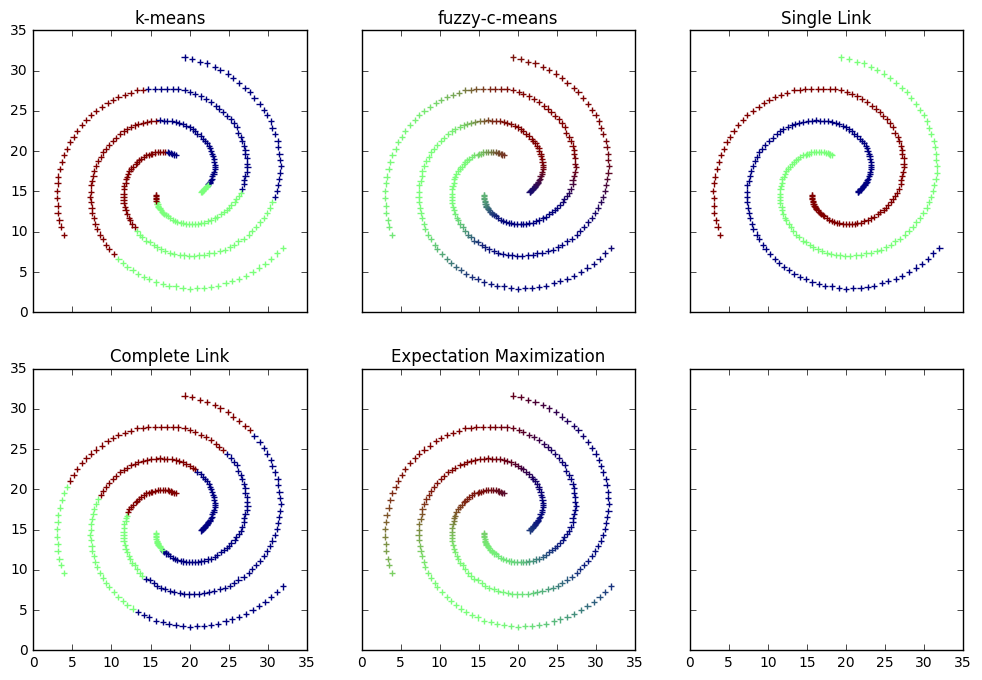

In [164]:
plt.close('all')
mpl.rcParams['figure.figsize'] = (12,8)

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, sharey='all', sharex='all')

plotClusters(datas[4],clustersSpiral[0],ax0)
ax0.set_title("k-means")

plotClusters(datas[4],clustersSpiral[1],ax1)
ax1.set_title("fuzzy-c-means")

plotClusters(datas[4],clustersSpiral[2],ax2)
ax2.set_title("Single Link")

plotClusters(datas[4],clustersSpiral[3],ax3)
ax3.set_title("Complete Link")

plotClusters(datas[4],clustersSpiral[4],ax4)
ax4.set_title("Expectation Maximization")

plt.show()

mpl.rcParams['figure.figsize'] = (6,4)

Von den in der Vorlesung vorgestellten und hier angewendeten Verfahren liefert keines ein überzeugendes Ergebnis. Single-Link ist das einzige dieser Verfahren, dass nicht nur konvexe Cluster liefern kann, das funktioniert aber nur, wenn es kein Rauschen auf den Daten gibt und die Punkte eines Clusters alle sehr ähnliche Abstände zueinander haben.

## Aufgabe 10.3: Clustering und Distanzen ##

### a) Probleme beim Clustering mit stark unterschiedlichen Varianzen ###
Zur Vereinfachung kann man einen zweidimensionalen Datensatz mit hoher Varianz entlang der x- und sehr kleiner Varianz entlang der y-Achse betrachten. Mehrere Klassen liegen dabei in langgestreckten Punktwolken relativ eng übereinander. Zum Beispiel Gramm Körpermasse auf der x-Achse und Schuhgröße auf der y-Achse - die Klassen könnten Männer und Frauen sein.  K-Means-Clustering geht von einer isotropen Verteilung aus und neigt deshalb eher zu runden (zweidimensional) als zu länglichen Clustern. Wenn die Varianzen stark unterschiedlich sind bedeutet das, dass mehr Gewichtung auf die Variable mit der kleineren Varianz gelegt wird. Das hat zur Folge, dass Cluster eher entlang von Variablen mit großer Varianz getrennt werden. 

### b) Ansätze zum Umgehen der Probleme ###

Um das Problem der unterschiedlichen Varianzen zu umgehen, sollten die Variablen vor einem Clustervergahren standardisiert werden. 
Wenn mehrere Variablen korreliert sind, bedeutet das, dass bestimmte Informationen mehrfach in die Clusterung eingehen. Abhilfe dagegen kann ein anderes Distanzmaß schaffen. Der Mahalanobis-Abstand ist zum Beispiel eine verallgemeinerung des Euklidischen-Abstands, welcher die Korrelation der Variablen berücksichtigt. 